# **Modèles pour classification textuelle**

Une fois les données nettoyées dans le notebook `1. Preprocessing` précédent, nous allons maintenant utiliser plusieurs modèles pour classifier les messages.

# 1. Avant propos et méthodologie

## 1.1 Premiers éléments

Nous allons faire de la classification textuelle avec _overlapping_ de labels. Il s'agit donc d'une _multilabel classification_ par opposition au _multiclass classification_ dans le cas où un seul label était possible par message. Pour traiter cela nous allons tout simplement séparer l'analyse en deux _binary classification_ simples : prédiction d'être `label 1` puis prédiction d'être `label 8`. La prédiction d'être `label 1:8` sera alors la simple combinaison des deux exercices précédents.


Par ailleurs les labels sont équilibrés, à priori pas besoin d'utiliser les méthodes spécifiques au _imbalanced dataset_ (cf. `0. EDA.ipynb`)

## 1.2 Vectorisation des textes nettoyés

Afin de réaliser l'exercice en un temps raisonnable je me suis limité à prendre les modèles "sur étagère" largement connus et utilisés par la communauté plutôt que des algorithmes plus de niche/_state of the art_.

Le premier choix concerne l'implémentation d'un modèle transformant le texte nettoyé en un vecteur analysable par un algorithme de classification dans un second temps. Ces `vectorizers` retenus sont par ordre de complexité :
- (Non implémenté) One-Hot Vectorizer/Bag of Words
- [TF-IDF](#31-tf_idf) : une matrice _document term_ de même taille que précédemment mais mieux pondérée, amélioration immédiate de la méthode précédente. Cette méthode, bien que simple, est souvent déjà très efficace lorsque la _downstream task_ est une classication usuelle comme le cas présent.
- [Embedding "statique" _a la_ word2vec](#32-doc2vec--word2vec-issu-de-spacy--moyenne-arithmétique) : moyenne arithmétique des word2vec pour faire un Doc2Vec
- (Non implémenté) Combinaison des deux méthodes pour faire du doc/sent2vec où les pondérations par mot sont données par le TF-IDF
- [Embedding "dynamique"](#33-transformers--camembert-roberta) en ayant recours à un transformers (partie encoder), ici camembert (BERT français)

## 1.3 Algorithmes de ML pour classification supervisée

Une fois la représentation vectorielle plus ou moins dense retenue, il faut recourir un à algorithme de classification classique du machine learning. Pour en citer quelques-uns :
- Régression logistique simple ou pénalisée (Ridge, Lasso)
- SVM, particulièrement efficace pour des tâches de classification textuelle dans la mesure où elle prend efficacement en compte les matrices _sparses_ de TF-IDF
- XGBoost : "roi des compétitions Kaggle"

Ces modèles peuvent chacun faire l'objet d'une _hyperparameter tuning_ pour améliorer les performances.

## 1.4 Métriques de succès

Puisque l'échantillon est quasi équilibré entre 1 et 8 (même lorsque qu'on attribue `1:8` à l'une ou l'autre des classes) l'accuracy toute simple pourrait être suffisante, alors que cette métrique est très peu utilisée usuellement (absolument pas pertinente dès lors que l'échantillon est déséquilibré, ce qui est généralement le cas en pratique - en tout cas dans mon expérience passée).

# 2. Packages usuels et importation

In [29]:
# Pour faciliter la mise à jour des fonctions écrites dans func_custom sans avoir à redémarrer le kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Packages classiques
import pandas as pd
import torch
import pickle
from scipy.stats import loguniform
import func_custom as fc

# NLP
import spacy
from transformers import CamembertModel, CamembertTokenizer

# Machine Learning
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report

In [31]:
df = pd.read_csv("data/data_clean.csv", sep = ";")

In [32]:
# Préparation des labels pour transformer la classification multilabel en deux classifications binaires classiques
df["label_1"] = df["label"].apply(lambda x : "1" in x)
df["label_8"] = df["label"].apply(lambda x : "8" in x)
y_1 = df["label_1"]
y_8 = df["label_8"]

In [33]:
# A changer pour créer le joblib associé à chaque label
y = y_8

my_random = 42
my_size = 0.2

# 3. Comparaison des modèles de vectorisation

## 3.1 TF_IDF

L'approche One-Hot Vectorizer/Bag of Words n'est pas montrée car le TF_IDF est une amélioration immédiation où au lieu d'avoir des simples 1 dans la matrice, les poids de chaque mots dans la phrase sont pondérés par un critère d'importance. La taille de la matrice reste cependnat la même.

In [34]:
messages = df["message_clean"]

# Si on voulait comparer les résultats en prenant des messages non nettoyés
# messages = df["message"].apply(lambda x: unicodedata.normalize("NFKC", x))

In [35]:
vectorizer = TfidfVectorizer(min_df = 2)
X_tfidf = vectorizer.fit_transform(messages)

In [36]:
# Pour illustrer la vectorisation de TF-IDF
pd.DataFrame(X_tfidf.toarray(), columns = vectorizer.get_feature_names_out()).head()

,abattement,abord,aboutir,absence,absolument,accepter,accessible,accident,accompagner,accord,...,étudiant,évaluer,éventuel,éventuellement,évidemment,évident,éviter,évoluer,évolution,événement
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171383
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [37]:
print(f"On constate que le dictionnaire du TF-IDF est de {X_tfidf.shape[1]} features")

On constate que le dictionnaire du TF-IDF est de 1479 features


In [38]:
# Similaire en tout point à 3.1 TF-IDF, on pourrait fonctionnariser cette partie

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, 
                                                    y, 
                                                    test_size = my_size,
                                                    stratify = y,
                                                    random_state = my_random)

clf_tfidf = LinearSVC(max_iter = 10000)
# D'autres algos de ML possibles, par exemple si XGBoost
# clf_tfidf = xgb.XGBClassifier()

clf_tfidf.fit(X_train, y_train)

y_pred = clf_tfidf.predict(X_test)
report = classification_report(y_test, y_pred)

In [39]:
print(report)

              precision    recall  f1-score   support

       False       0.84      0.88      0.86        60
        True       0.91      0.88      0.89        80

    accuracy                           0.88       140
   macro avg       0.88      0.88      0.88       140
weighted avg       0.88      0.88      0.88       140



Le F1-score (de la cible) est de 84%, ce qui peut sembler à priori satisfaisant pour un entraînement sur petit échantillon.

In [40]:
# Code "à la main" pour créer la visualisation des plus grandes contributions

coef = clf_tfidf.coef_[0]
vocabulary_positions = coef.argsort()
vocabulary = vectorizer.get_feature_names_out()

top_words = 10
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

df_contrib = pd.DataFrame([[vocabulary[c], coef[c]] for c in top_positive_coef + top_negative_coef], 
                          columns = ["feature", "coefficient"]).sort_values("coefficient")

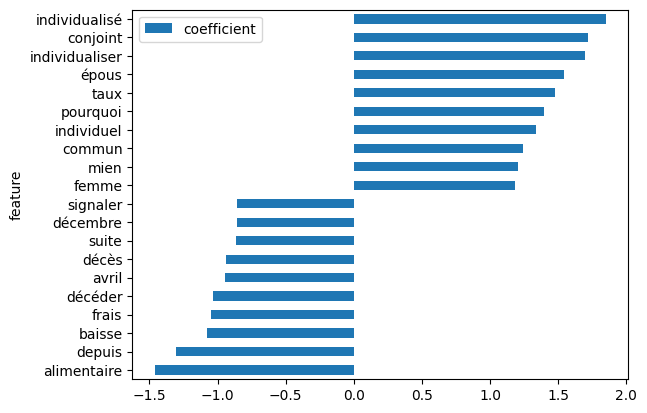

In [41]:
_ = df_contrib.set_index("feature").plot.barh()

**Que représentent les labels ?**

L'analyse de ces mots puis des messages à l'oeil nu me laisse entendre que la distinction entre 1 et 8 n'est pas "topic related" mais plutôt sur la teneur de demande :
- Les 1 sont de simples demandes d'aide, notamment pour effectuer un changement de taux, signaler un changement de situation ("depuis" indique souvent que la personne indique un changement de situation "depuis", de même pour "suite")
- Les 8 sont à l'inverse des plaintes, la situation constatée par le contribuable ne correspond pas à l'attendu et il souhaite une explication (`Pourquoi ??`)

In [42]:
# En utilisant XGBoost cela aurait permit aussi une visualisation intégrée

# _ = xgb.plot_importance(classifier, 
#                         importance_type = "gain",
#                         max_num_features = 25,
#                         show_values = False)

In [43]:
with open('predictor/vectorizer_tfidf.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

## 3.2 Doc2Vec : Word2Vec issu de Spacy + moyenne arithmétique

Les messages adressés par les contribuables sont rédigés dans une langue orale/écrite courante et **ne présente pas de termes techniques/jargon spécifique**. Un embedding entraîné sur un corpus usuel sera donc suffisant pour ne pas entraîner de problème de dictionnaire. J'ai retenu par simplicité d'utilisation celui présent sur Spacy. Par économie de taille on pourrait retenir le "medium", dans l'espoir d'avoir les meilleurs résultats possibles j'importe cependant le "large".

In [44]:
nlp = spacy.load("fr_core_news_lg")

In [45]:
df_spacy = df.copy()

In [46]:
df_spacy["embedding_avg"] = df_spacy["message_clean"].apply(lambda x: nlp(x).vector) 

L'attribut `doc.vector` donne l'embedding par moyenne arithmétique des mots de la phrase.

Cette stratégie n'est pas très pertinente pour de longs messages, en effet en attribuant des poids identiques à tous les mots - dont certains fréquents non retirés par les stopwords - on "brouille" le message, il n'y a pas de raisons pour que la moyenne reflète parfaitement la teneur moyenne du message. Une amélioration, non implémentée, serait déjà de repondérer le message par les poids de la matrice TF-IDF.

In [47]:
# Reconstruction de la matrice X pas forcément très élégante mais fonctionne et pas très longue à tourner
X_spacy = pd.DataFrame()
for elem in df_spacy["embedding_avg"]:
    temp = (pd.DataFrame((elem)).T)
    X_spacy = pd.concat([X_spacy, temp])

In [48]:
print(f"On passe des {X_tfidf.shape[1]} features du TF-IDF à {X_spacy.shape[1]} features ici")

On passe des 1479 features du TF-IDF à 300 features ici


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_spacy, 
                                                    y, 
                                                    test_size = my_size,
                                                    stratify = y,
                                                    random_state = my_random)

clf_spacy = LinearSVC()
clf_spacy.fit(X_train, y_train)

y_pred = clf_spacy.predict(X_test)
report = classification_report(y_test, y_pred)

In [50]:
print(report)

              precision    recall  f1-score   support

       False       0.83      0.80      0.81        60
        True       0.85      0.88      0.86        80

    accuracy                           0.84       140
   macro avg       0.84      0.84      0.84       140
weighted avg       0.84      0.84      0.84       140



Comme attendu les performances sont bien plus décevantes, on moyennise brutallement une longue phrase en prenant la moyenne arithmétique des embedding de chaque mot, il est très peu probablement que la moyenne non pondérée donne quelque chose de pertinent au niveau de la phrase entière. On peut s'attendre à une amélioration du score avec repondération TF-IDF, mais peut-être toujours moins performante que le TF-IDF.

## 3.3 Transformers : Camembert (RoBERTa)

Nous allons avoir recours à des transfomers et plus particulièrement ceux présentant uniquement la partie encodage de façon à avoir une réprenstation dense de la phrase. Il s'agit donc des modèles BERT (au lieu des GPT génératifs). Classiquement j'ai recours à HuggingFace pour utiliser facilement des modèles pré-entraînés, et notamment ici [CamemBERT](https://huggingface.co/almanach/camembert-base)

On aurait également pu passer par Spacy qui dispose d'une façon simple d'implémenter un transformers français https://spacy.io/models/fr#fr_dep_news_trf

J'utilise ici une méthode simple plutôt qu'un fine-tuning PyTorch (https://camembert-model.fr/posts/tutorial_part2/) : je garde figé tous les paramètres du modèles pour n'utiliser que les embeddings en sortie de Camembert comme input d'une simple classification ML.

In [51]:
# You can replace "camembert-base" with any other model from the table, e.g. "camembert/camembert-large".
tokenizer = CamembertTokenizer.from_pretrained("camembert/camembert-base-wikipedia-4gb")
camembert = CamembertModel.from_pretrained("camembert/camembert-base-wikipedia-4gb")

c:\Users\TitouanBlaize\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [52]:
to_run = False

if to_run :
    # Méthode à la main pour récupérer les embeddings de la dernière couche de CamemBERT et constituer la dataframe X utile à l'algo de ML
    n_truncated = 0
    df_camembert  = pd.DataFrame()
    for index, row in df.iterrows():
        message_raw = row["message"]

        tokenized_sentence = tokenizer.tokenize(message_raw)

        encoded_sentence = tokenizer.encode(tokenized_sentence)

        # Par simplicité je coupe au maximum du "maximum context size" de CamemBERT
        # Possibilité d'itérer sur des batch de 512 jusqu'à avoir tout le texte puis de moyenniser
        if (len(encoded_sentence) > 512) :
            encoded_sentence = encoded_sentence[:511]
            n_truncated += 1 # Pour savoir le nombre de phrases tronquées
            
        encoded_sentence = torch.tensor(encoded_sentence).unsqueeze(0)

        results_camembert = camembert(encoded_sentence)

        # last_hidden_state.detach() permet d'aller chercher la dernière couche de CamemBERT
        # [:,0,:] pour prendre le premier token [CLS] qui contient toute l'information de la phrase
        new_row = pd.DataFrame(results_camembert.last_hidden_state.detach()[:,0,:])
        df_camembert = pd.concat([df_camembert, new_row], ignore_index = True)

    # Sauvegarde pour gagner du temps
    df_camembert.to_csv("data/data_camembert.csv", sep = ";", index = False)
else :
    df_camembert = pd.read_csv("data/data_camembert.csv", sep = ";")

In [53]:
X_bert = df_camembert

X_train, X_test, y_train, y_test = train_test_split(X_bert, 
                                                    y, 
                                                    test_size = my_size,
                                                    stratify = y,
                                                    random_state = my_random)

clf_bert = LinearSVC()
clf_bert.fit(X_train, y_train)

y_pred = clf_bert.predict(X_test)
report = classification_report(y_test, y_pred)

In [54]:
print(report)

              precision    recall  f1-score   support

       False       0.84      0.87      0.85        60
        True       0.90      0.88      0.89        80

    accuracy                           0.87       140
   macro avg       0.87      0.87      0.87       140
weighted avg       0.87      0.87      0.87       140



# 4. Optimisation par RandomizedSearchCV

Je ne pousse pas l'optimisation des hyperparamètres à son maximum mais illustre juste l'intérêt de cette technique pour améliorer les résultats, prévenir l'overfitting, donner une meilleure estimation des métriques que sur un simple split. Réalisons cela sur le TF-IDF qui semblait avoir les meilleures performances.

In [55]:
param_dist = {
    'C': loguniform(1e-1, 1e1),  # Regularization parameter (log-uniform distribution)
    'loss': ['hinge', 'squared_hinge']  # Loss function
}

random_search = RandomizedSearchCV(clf_tfidf, 
                                   param_distributions = param_dist, 
                                   n_iter = 30, 
                                   cv = 5, 
                                   scoring = 'f1', 
                                   random_state = my_random)


random_search.fit(X_tfidf, y)

print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

best_model = random_search.best_estimator_

Best parameters found:  {'C': 0.1171593739230706, 'loss': 'squared_hinge'}
Best cross-validation score: 0.88


Grâce à l'optimization nous avons robustifié la valeur du F1 score sur échantillon test (85% pour label 1) et augmenté ce dernier par rapport au split avec seed = 42.

In [56]:
import joblib
joblib_file = "predictor/tfidf_label8.joblib"
joblib.dump(best_model, joblib_file)

['predictor/tfidf_label8.joblib']